In [1]:
import cpm
from packaging import version

## cpm checks
print(cpm.__version__)
if version.parse(cpm.__version__) < version.parse("0.22"):
    raise ImportError("cpm version must be >= 0.22. Please install the latest version using: pip install --upgrade cpm")

0.23.3


# EXERCISE 1

In this exercise, you will use the model you implemented in Exercise 1 to fit some real-world data. Then you will repeat the same process with a hierarchical modeling approach.

## EXERCISE 2.1: Import the data and your model from Exercise 1

In [2]:
import numpy
import pandas as pd
import cpm
import cpm.datasets as datasets
from cpm.generators import Parameters, Value
import ipyparallel as ipp  # for parallel computing with ipython (specific for Jupyter Notebook)

data = datasets.load_bandit_data()
data.head()

parameters = Parameters(
    # free parameters are indicated by specifying priors
    alpha=Value(
        value=0.5,
        lower=1e-10,
        upper=1,
        prior="truncated_normal",
        args={"mean": 0.25, "sd": 0.25},
    ),
    temperature=Value(
        value=1,
        lower=0,
        upper=10,
        prior="truncated_normal",
       args={"mean": 5, "sd": 2.5},
    ),
    # everything without a prior is part of the initial state of the
    # model or constructs fixed throughout the simulation
    # (e.g. exemplars in general-context models of categorizations)
    # initial q-values starting starting from non-zero value
    # these are equal to all 4 stimuli (1 / 4)
    values = numpy.array([0.25, 0.25, 0.25, 0.25])
    )

@ipp.require("numpy")
def model(parameters, trial):
    # pull out the parameters
    alpha = parameters.alpha
    temperature = parameters.temperature
    values = numpy.array(parameters.values)
    
    # pull out the trial information
    stimulus = numpy.array([trial.arm_left, trial.arm_right]).astype(int)
    feedback = numpy.array([trial.reward_left, trial.reward_right])
    human_choice = trial.response.astype(int)

    # Equation 1. - get the value of each available action
    # Note that because python counts from 0, we need to shift
    # the stimulus identifiers by -1
    expected_rewards = values[stimulus - 1]
    # convert columns to rows
    expected_rewards = expected_rewards.reshape(2, 1)
    # calculate a policy based on the activations
    # Equation 2.
    choice_rule = cpm.models.decision.Softmax(
        activations=expected_rewards,
        temperature=temperature
        )
    choice_rule.compute() # compute the policy
    # if the policy is NaN for an action, then we need to set it to 1
    # this corrects some numerical issues with python and infinities
    if numpy.isnan(choice_rule.policies).any():
        choice_rule.policies[numpy.isnan(choice_rule.policies)] = 1
    # get the received reward for the choice
    reward = feedback[human_choice]
    teacher = numpy.array([reward])
    # we now create a vector that tells our learning rule what...
    # ... stimulus to update according to the participant's choice
    what_to_update = numpy.zeros(4)
    chosen_stimulus = stimulus[human_choice] - 1
    what_to_update[chosen_stimulus] = 1

    # Equation 4.
    update = cpm.models.learning.SeparableRule(
                    weights=values,
                    feedback=teacher,
                    input=what_to_update,
                    alpha=alpha
                    )
    update.compute()
    # Equation 5.
    values += update.weights.flatten()
    # compile output
    output = {
        "trial"    : trial.trial.astype(int), # trial numbers
        "activation" : expected_rewards.flatten(), # expected reward of arms
        "policy"   : choice_rule.policies,       # policies
        "reward"   : reward,                  # received reward
        "error"    : update.weights,          # prediction error
        "values"   : values,                  # updated values
        # dependent variable
        "dependent"  : numpy.array([choice_rule.policies[1]]),
    }
    return output

generative_model = cpm.generators.Wrapper(
    model=model,
    parameters=parameters,
    data=data[data == 1],
)

## EXERCISE 3.2: Fit the model to the data


### EXERCISE 3.2.1: Specify your discrepency function


Here is a reminder of the loss function from the slides:

\begin{align*}
-\log L(\theta \mid Y, M) = -\sum_{i=1}^{N} \log \bigg[ p(y_i \mid \theta) \bigg]
\end{align*}

where $\theta$ are model parameters, $Y$ is the data with $N$ number of data points, and $M$ is the model. The $p(y~|~\theta)$ gives the probability of observing the data given a certain parameter set. It follows a _Bernoulli_ distribution and defined such as:


\begin{align*}
p(y_t~|~\theta) = \left\{ \begin{array}{ll} P(a_t) &
\text{if } y = 1, \text{ and} \\ 1 - P(a_t) & \text{if } y = 0.
\end{array} \right.
\end{align*}


Rest assured, you do not have to worry about the math here, as the `cpm` toolbox will take care of it for you. `cpm.optimisation.minimise` has various options for the discrepancy function, including `cpm.optimisation.minimise.LogLikelihood.bernoulli`. See its documentation [here](https://devcompsy.github.io/cpm/references/optimisation/#cpm.optimisation.minimise.LogLikelihood.bernoulli). Under the hood, it will calculate the log-likelihood of the Bernoulli distribution for you, given the data and the model parameters, and return the negative log-likelihood as the discrepancy function. This is an example code for the discrepancy function:

In [3]:
def my_loss_function(observed, predicted):
        limit = np.log(1e-200)
        bound = np.finfo(np.float64).min
        probabilities = predicted.flatten()
        numpy.clip(probabilities, 1e-100, 1 - 1e-100, out=probabilities)

        LL = bernoulli.logpmf(k=observed.flatten(), p=probabilities)
        LL[LL < bound] = limit  # Set the lower bound to avoid overflow
        NLL = -1 * np.sum(LL)
        return NLL

### EXERCISE 3.2.3: Fit the model

Similarly to how we did in Exercise 2, you will specify the `observed` variable in the data, then use `FminBound` to fit the model to the data. You will need to specify the model you are running, the data, the minimisation (discrepency) function. See the documentaiton [here](https://devcompsy.github.io/cpm/references/optimisation/#cpm.optimisation.FminBound) for details on what you can specify and how to fill in the blanks below.


In [4]:
from cpm.optimisation import minimise, FminBound

data["observed"] = data["response"].astype(int)  # convert response to int

# Set up the fitting procedure
fit = FminBound(
    model=generative_model,  # Wrapper class with the model we specified from before
    data=data.groupby('ppt'),  # the data as a list of dictionaries
    minimisation=minimise.LogLikelihood.bernoulli,  # use the log-likelihood for Bernoulli distribution
    parallel=True,
    libraries=["numpy", "cpm", "pandas"],
    prior=False,
    ppt_identifier="ppt",
    display=False,
    number_of_starts=5,
    # everything below is optional and passed directly to the scipy implementation of the optimiser
    approx_grad=True

)

fit.optimise()

Starting optimization 1/5 from [0.87461866 0.2747856 ]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

Starting optimization 2/5 from [0.13755474 6.32579567]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

Starting optimization 3/5 from [0.8568261 0.5030843]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

Starting optimization 4/5 from [0.64819422 4.68331715]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

Starting optimization 5/5 from [0.28828706 8.61357347]
Starting 10 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/10 [00:00<?, ?engine/s]

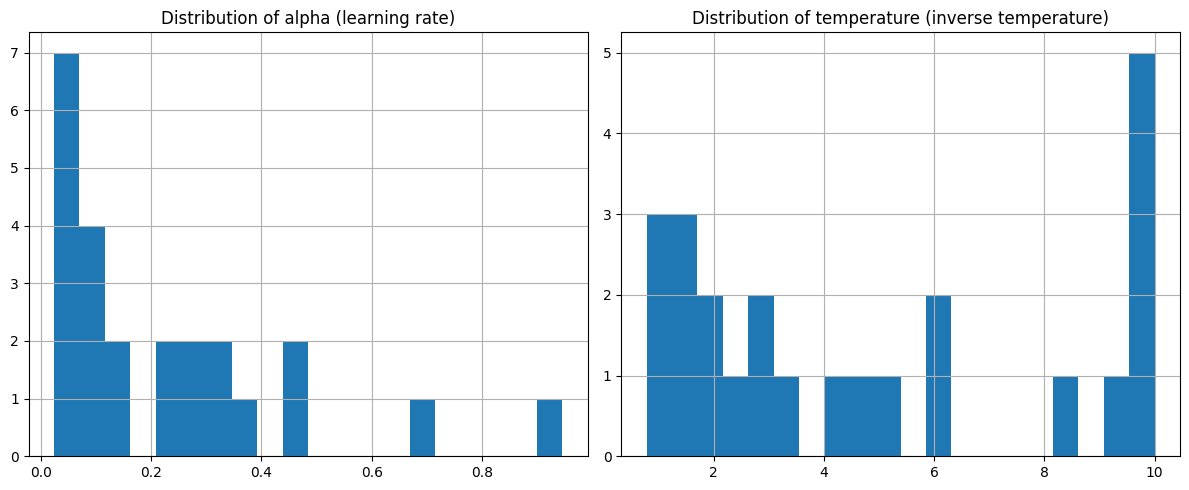

In [5]:
parameter_estimates_non_hierarchical = fit.export()
parameter_estimates_non_hierarchical.rename(
    columns={
        "x_0": "alpha",
        "x_1": "temperature",
    },
    inplace=True
)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

parameter_estimates_non_hierarchical.alpha.hist(bins=20, ax=axs[0])
parameter_estimates_non_hierarchical.temperature.hist(bins=20, ax=axs[1])

axs[0].set_title("Distribution of alpha (learning rate)")
axs[1].set_title("Distribution of temperature (inverse temperature)")
plt.tight_layout()
plt.show()

## EXERCISE 3.3: Hierarchical modeling

Now, how do we turn our model into a hierarchical model? The idea is to assume that the parameters of the model are not fixed, but rather drawn from a distribution. The variance between subject-level parameters are constrained through the priors drawn over the parameter space. But, hey! We have already defined the priors in Exercise 1, so we can just use those. The way to use them is to flip a switch in the optimisation function by setting the option related to priors True. Find the relevant function argument in the online [documentation of FminBound](https://devcompsy.github.io/cpm/references/optimisation/#cpm.optimisation.FminBound) and insert it into the code below!

In [6]:
from cpm.optimisation import minimise, FminBound

data["observed"] = data["response"].astype(int)  # convert response to int

# Set up the fitting procedure
fit = FminBound(
    model=generative_model,  # Wrapper class with the model we specified from before
    data=data.groupby('ppt'),  # the data as a list of dictionaries
    minimisation=minimise.LogLikelihood.bernoulli,
    parallel=True,
    libraries=["numpy", "cpm", "pandas"],
    prior=True,  # !!! use priors for the parameters
    ppt_identifier="ppt",
    display=False,
    number_of_starts=5,
    cl=5,
    # everything below is optional and passed directly to the scipy implementation of the optimiser
    approx_grad=True

)

fit.optimise()

Starting optimization 1/5 from [0.24678605 0.61555417]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

Starting optimization 2/5 from [0.10538978 9.48081351]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

Starting optimization 3/5 from [0.24403711 9.23621743]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

Starting optimization 4/5 from [0.28541955 0.89483476]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

Starting optimization 5/5 from [0.52398999 1.67900012]
Starting 5 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>


  0%|          | 0/5 [00:00<?, ?engine/s]

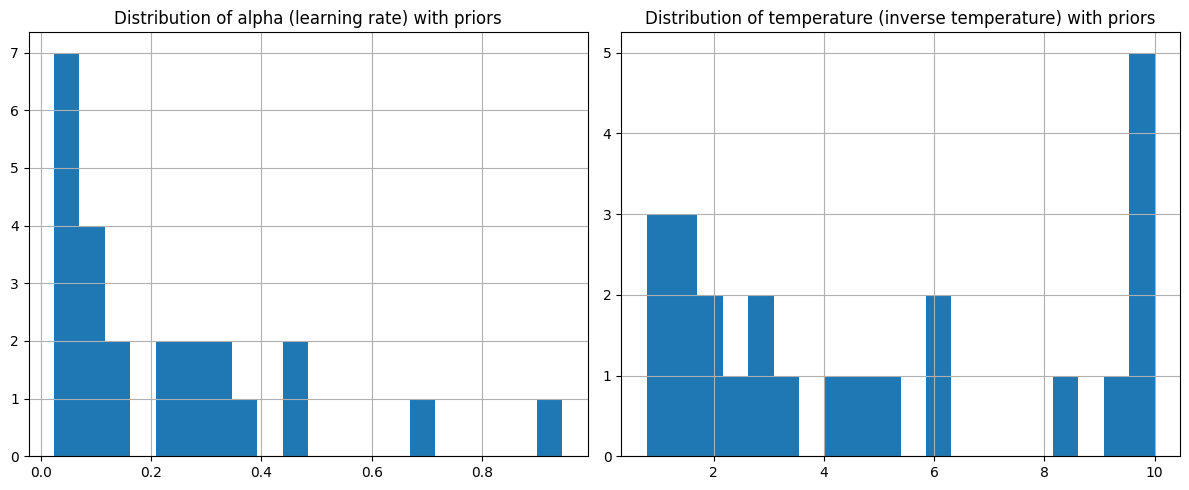

In [7]:
parameter_estimates_with_hierarchical = fit.export()
parameter_estimates_with_hierarchical.rename(
    columns={
        "x_0": "alpha",
        "x_1": "temperature",
    },
    inplace=True
)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

parameter_estimates_non_hierarchical.alpha.hist(bins=20, ax=axs[0])
parameter_estimates_non_hierarchical.temperature.hist(bins=20, ax=axs[1])

axs[0].set_title("Distribution of alpha (learning rate) with priors")
axs[1].set_title("Distribution of temperature (inverse temperature) with priors")
plt.tight_layout()
plt.show()

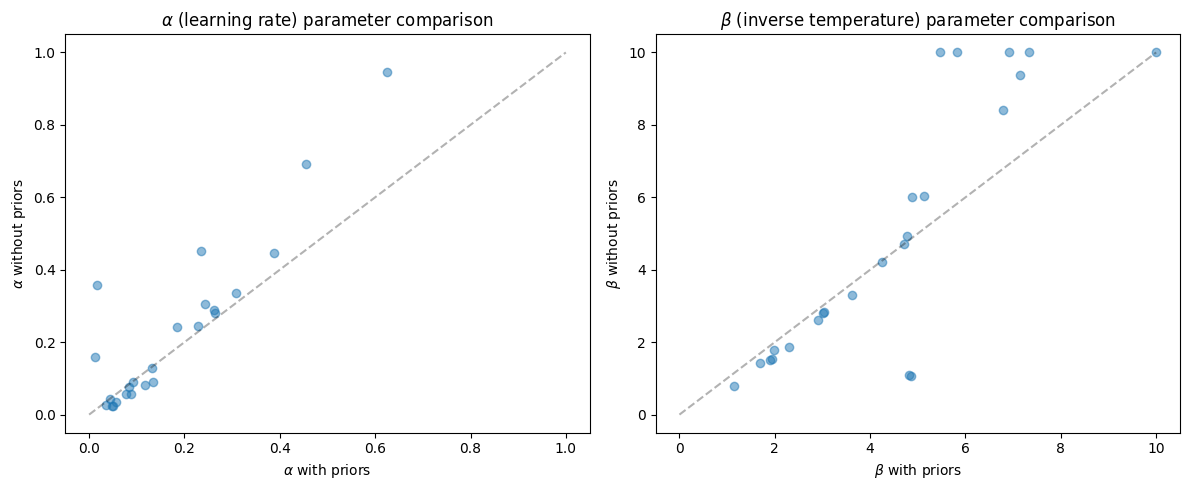

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(
    parameter_estimates_with_hierarchical.alpha,
    parameter_estimates_non_hierarchical.alpha,
    "o",
    alpha=0.5,
    label="Non-hierarchical"
)
ax[0].set_ylabel(r"$\alpha$ without priors")
ax[0].set_xlabel(r"$\alpha$ with priors")
ax[0].set_title(r"$\alpha$ (learning rate) parameter comparison")
ax[0].plot([0, 1], [0, 1], "k--", alpha=0.3)  # reference line

ax[1].plot(
    parameter_estimates_with_hierarchical.temperature,
    parameter_estimates_non_hierarchical.temperature,
    "o",
    alpha=0.5,
    label="Non-hierarchical"
)
ax[1].set_ylabel(r"$\beta$ without priors")
ax[1].set_xlabel(r"$\beta$ with priors")
ax[1].set_title(r"$\beta$ (inverse temperature) parameter comparison")
ax[1].plot([0, 10], [0, 10], "k--", alpha=0.3)  # reference line

plt.tight_layout()
plt.show()

## Questions

- What is the difference between the model you fitted in Exercise 2 and the one you will fit here?
- What did you learn about the impact of priors on parameter estimation?
- What differences you notice between the results of the two parameter estimations? Is it better, worse, or the something else?
- In what situations would you prefer a hierarchical model over a non-hierarchical one?
- How confident are you in the parameter estimates, and what could increase your confidence?

## Extra information

The `cpm` toolbox is designed to be modular. Which means that the tools we implement work together, such that once you have a model, you can use it with any of the optimisation methods we provide. This is why we can use the same model with `FminBound` and `DifferentialEvolution`, or why you can flip a switch to enable hierarchical modeling.
The feature I want to draw your attention is that once we estimated model parameters, we can use them to simulate latent variables for each participant. Simple take the `fit.parameters` and use them in `cpm.generators.Simulator` to simulate with the model on participant's data. 

In [9]:

simulate =  cpm.generators.Simulator(
    wrapper=generative_model,
    parameters=fit.parameters,
    data=data.groupby('ppt'),
)
simulate.run()
simulations_multiple_ppt = simulate.export()

/var/folders/w1/7prlf4xs12536zfppmztb1_m0000gn/T/ipykernel_86011/2040811395.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  values = numpy.array(parameters.values)
/var/folders/w1/7prlf4xs12536zfppmztb1_m0000gn/T/ipykernel_86011/2040811395.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  values = numpy.array(parameters.values)
/var/folders/w1/7prlf4xs12536zfppmztb1_m0000gn/T/ipykernel_86011/2040811395.py:40: DeprecationWarning: __array__ implementation doesn't acce

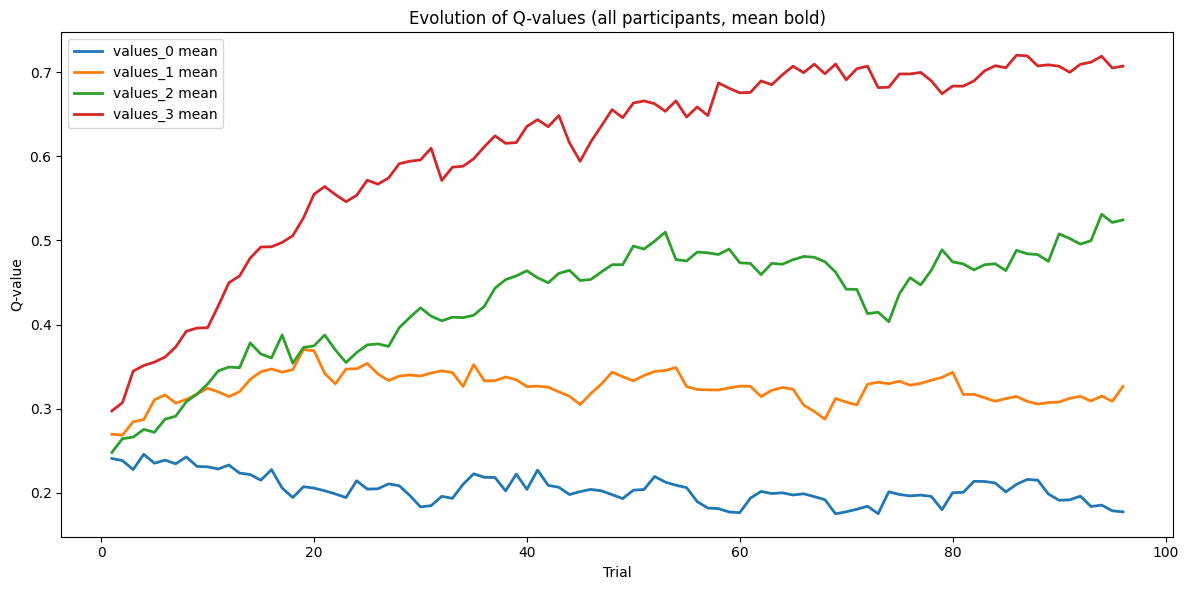

In [13]:
import matplotlib.pyplot as plt

participants = simulations_multiple_ppt['ppt'].unique()
n_participants = len(participants)

fig, ax = plt.subplots(figsize=(12, 6))

value_cols = ['values_0', 'values_1', 'values_2', 'values_3']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for vcol, color in zip(value_cols, colors):
    # Plot mean Q-value across participants for each stimulus
    mean_vals = simulations_multiple_ppt.groupby('trial_0')[vcol].mean()
    ax.plot(mean_vals.index, mean_vals.values, color=color, linewidth=2, label=f'{vcol} mean')

ax.set_ylabel('Q-value')
ax.set_xlabel('Trial')
ax.set_title('Evolution of Q-values (all participants, mean bold)')
ax.legend()
plt.tight_layout()
plt.show()